<a href="https://colab.research.google.com/github/Morilla123/Curso/blob/main/Copia_de_Transformers_medicina_extraccion_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Extraccion de informacion de reportes medicos

El objetivo de este proyecto es extraer desde un reporte medico que contiene texto libre, informacion del paciente, informacion de la medicacion del paciente, y una imagen de un radiografia de torax, lo siguiente:

- Texto del reporte de-identificado (sin informacion personal del paciente)
- Medicamentos con los que es tratado el paciente
- Prediccion de si en la radiografia es normal o presenta neumonia

Documento a analizar: [Reporte](https://drive.google.com/file/d/15zA5XDQfrVIYZk0gHGLxQqt_up7-NjuP/view?usp=sharing)

*1*) De-identificar texto (quitar informacion personal)

2) Obtener medicamentos del paciente

3) Predecir si la radiografia corresponde a un paciente normal o con neumonia

## Anonimizacion (nombres)

In [ ]:
%%capture
! pip install transformers datasets
from transformers import AutoTokenizer, TFAutoModelForQuestionAnswering
import tensorflow as tf
!pip install spacy
from spacy import displacy
import spacy

text = "Name: Matias Molinas Birth date: 10/03/1918 (54) 342- 5678906 Significant Medical History Mr. Matias Molinas is a 52 y/o accountant with hypercholesterolemia and polycythemia vera who has been in relatively good health. Diagnostic: Patient needs to take 50 mg of ibuprofen. Chest X-Ray:"


In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
doc = nlp(text)
displacy.render(doc, style='ent')

'<div class="entities" style="line-height: 2.5; direction: ltr">Name: \n<mark class="entity" style="background: #aa9cfc; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">\n    Matias Molinas Birth\n    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; text-transform: uppercase; vertical-align: middle; margin-left: 0.5rem">PERSON</span>\n</mark>\n date: \n<mark class="entity" style="background: #bfe1d9; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">\n    10/03/1918\n    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; text-transform: uppercase; vertical-align: middle; margin-left: 0.5rem">DATE</span>\n</mark>\n (\n<mark class="entity" style="background: #e4e7d2; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">\n    54\n    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; 

In [ ]:
for ent in doc.ents:
    print(ent.text, ent.label_)

Matias Molinas Birth PERSON
10/03/1918 DATE
54 CARDINAL
5678906 CARDINAL
Matias Molinas PERSON
52 y QUANTITY
50 mg TIME
Chest X-Ray PERSON


In [ ]:
# The start_char of each entity PER
per_starts = [ent.start_char for ent in doc.ents if ent.label_ == 'PERSON']

# The end_char of each entity PER
per_ends = [ent.end_char for ent in doc.ents if ent.label_ == 'PERSON']

# print(f'per_start: {per_starts}\nper_ends: {per_ends}')

In [ ]:
# colaboration https://github.com/mnsosa/ner/blob/main/ner_spanish_ialab.ipynb
# Anonymization
text_anon = doc.text[0:per_starts[0]]
text_anon = text_anon + '<NOMBRE>'

per = 1
while per < len(per_starts):
    text_anon = text_anon + doc.text[per_ends[per-1]:per_starts[per]] + '<NOMBRE> '
    per = per + 1

In [ ]:
text_anon

'Name: <NOMBRE> date: 10/03/1918 (54) 342- 5678906 Significant Medical History Mr. <NOMBRE>  is a 52 y/o accountant with hypercholesterolemia and polycythemia vera who has been in relatively good health. Diagnostic: Patient needs to take 50 mg of ibuprofen. <NOMBRE> '

## Extract list of drugs and disease


Import librerias


In [ ]:
%%capture
import requests

In [ ]:
def Use_API(text, url="https://bern.korea.ac.kr/plain"):          # API = https://bern.korea.ac.kr/#
  return requests.post(url, data={'sample_text': text}).json()

In [ ]:
def Extraxtion_data(text,out,type):

  denotations=out['denotations']
  relavent_terms=[]
  
  if type=='drug':
    drug_terms=[]
    for i in denotations:
      if i['obj']== 'drug':
        drug_terms.append((i['span']['begin'],i['span']['end']))
   
    for i in drug_terms:
      start=i[0]
      end=i[1]
      relavent_terms.append(text[start:end])

  if type=='disease':
    species_terms=[]
    for i in denotations:
      if i['obj']== 'disease':
        species_terms.append((i['span']['begin'],i['span']['end']))
    
    for i in species_terms:
      start=i[0]
      end=i[1]
      relavent_terms.append(text[start:end])


  # if type=='species':
  #   species_terms=[]
  #   for i in denotations:
  #     if i['obj']== 'species':
  #       species_terms.append((i['span']['begin'],i['span']['end']))
    
  #   for i in species_terms:
  #     start=i[0]
  #     end=i[1]
  #     relavent_terms.append(text[start:end])

  return(relavent_terms)

In [ ]:
# text = "X-rays were negative and physical assessment determined soft tissue damage to the lateral aspect of her ankle. She was initially treated with ice, an ace wrap, crutches and mild pain medications (Tylenol with codeine)"
text = "Name: Matias Molinas Birth date: 10/03/1918 (54) 342- 5678906 Significant Medical History Mr. Matias Molinas is a 52 y/o accountant with hypercholesterolemia and polycythemia vera who has been in relatively good health. Diagnostic: Patient needs to take 50 mg of ibuprofen. Chest X-Ray:"

In [ ]:
out=Use_API(text)
# print(out)
# print(Extraxtion_data(text,out,'drug'))
List_Drugs = Extraxtion_data(text,out,'drug')
# print(Extraxtion_data(text,out,'disease'))
List_Disease = Extraxtion_data(text,out,'disease')

In [ ]:
print(List_Drugs, List_Disease)

['ibuprofen'] ['hypercholesterolemia', 'polycythemia vera']


## image extract (check input path)

In [ ]:
%%capture
!pip install PyMuPDF
import fitz

In [ ]:
file_path = input("Enter the PDF file path")
pdf_file = fitz.open(file_path)



#Reading the location where to save the file
location = input("Enter the location to save: ")


#finding number of pages in the pdf
number_of_pages = len(pdf_file)

#iterating through each page in the pdf
for current_page_index in range(number_of_pages):
  #iterating through each image in every page of PDF
  for img_index,img in enumerate(pdf_file.getPageImageList(current_page_index)):
        xref = img[0]
        image = fitz.Pixmap(pdf_file, xref)
        #if it is a is GRAY or RGB image
        if image.n < 5:        
            image.writePNG("{}/image{}-{}.png".format(location,current_page_index, img_index))
        #if it is CMYK: convert to RGB first
        else:                
            new_image = fitz.Pixmap(fitz.csRGB, image)
            new_image.writePNG("{}/image{}-{}.png".foramt(location,current_page_index, img_index))
            

Enter the PDF file path/content/Report.pdf
Enter the location to save: /content/


Deprecation: 'getPageImageList' removed from class 'Document' after v1.19.0 - use 'get_page_images'.
Deprecation: 'writePNG' removed from class 'Pixmap' after v1.19.0 - use 'save'.


## Dataset

In [1]:
%%capture
!pip install kaggle --upgrade

In [2]:
! mkdir ~/.kaggle # simplemente creo una carpeta en colab pero en la raiz

In [3]:
! cp kaggle.json ~/.kaggle/ # mueve el kaggle jonson para la carpeta que acabamos de crear

In [4]:
! chmod 600 ~/.kaggle/kaggle.json # es como el permiso para que funque

In [5]:
%%capture
! kaggle datasets download paultimothymooney/chest-xray-pneumonia

In [ ]:
# %%capture
! unzip chest-xray-pneumonia.zip

In [7]:
%%capture
!pip install -U tensorflow-addons

## Create Baseline

In [ ]:
%%capture
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2 # import cv2

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random
import os

In [ ]:
DIR = os.listdir('/content/chest_xray')

train_folder = '/content/chest_xray/train'
test_folder = '/content/chest_xray/test'
val_folder = '/content/chest_xray/val'

In [ ]:
IMG_SIZE = 50 # resize image, see  u  later             -----------------------------------------------------------------------

In [ ]:
labels = ["NORMAL", "PNEUMONIA"] # each folder has two sub folder name "PNEUMONIA", "NORMAL"

def get_data_train(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([new_array, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
train = get_data_train(train_folder)
test = get_data_train(test_folder)
val = get_data_train(val_folder)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


l = []                    <--------------- make the variable understandable

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


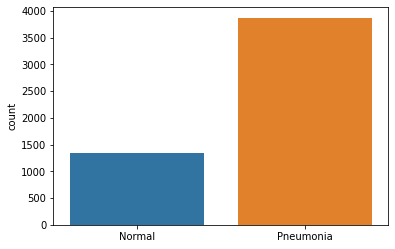

In [ ]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Normal")
    else:
        l.append("Pneumonia")

min([], default="EMPTY")
sns.countplot(l)

In [ ]:
X_train = []
y_train = []

X_val = []
y_val = []

X_test = []
y_test = []

for feature, label in train:
    X_train.append(feature)
    y_train.append(label)

for feature, label in test:
    X_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    X_val.append(feature)
    y_val.append(label)

In [ ]:
X_train = np.array(X_train) / 255
X_val = np.array(X_val) / 255
X_test = np.array(X_test) / 255 # normalizacion

In [ ]:
# print(X_test.shape, X_val.shape, X_test.shape )

In [ ]:
X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_train = np.array(y_train)

X_val = X_val.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_val = np.array(y_val)

X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_test = np.array(y_test)

In [ ]:
# print(X_test.shape, X_val.shape, X_test.shape )

In [ ]:
%%capture
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Conv2D, Activation, Dense, Dropout, MaxPooling2D
from tensorflow.keras.models import Sequential

Create vanillia model 

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding="same", input_shape=X_train.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation="relu"))

model.add(Dense(1))
model.add(Activation("sigmoid"))

In [ ]:
%%capture
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=25, validation_data=(X_val, y_val), shuffle=True)
scores = model.evaluate(X_test, y_test)

In [ ]:
model.save("cnn_baseline.model")

In [ ]:
# scores
print("Test loss {}".format(scores[0]))
print("Test accuracy {}".format(scores[1]))

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

In [ ]:
predict_x=model.predict(X_test) 
prediction=np.argmax(predict_x,axis=1)
prediction[:15]

In [ ]:
correct = np.nonzero(prediction == y_test)[0]
incorrect = np.nonzero(prediction != y_test)[0]

In [ ]:
# correc
j = 0
for i in correct[:6]:
    plt.subplot(3,2,j+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[i].reshape(50,50), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(prediction[i], y_test[i]))
    plt.xlabel(labels[prediction[i]])
    plt.tight_layout()
    j += 1

In [ ]:
# incorrect
j = 0
for i in incorrect[:6]:
    plt.subplot(3,2,j+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[i].reshape(50,50), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(prediction[i], y_test[i]))
    plt.xlabel(labels[prediction[i]])
    plt.tight_layout()
    j += 1

In [ ]:
labels = ["NORMAL", "PNEUMONIA"]
def prepare(filepath):
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

model = tf.keras.models.load_model("cnn_baseline.model") # load model

In [ ]:
labels = ["NORMAL", "PNEUMONIA"]
def prepare(filepath):
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

model = tf.keras.models.load_model("cnn_baseline.model") # load model

## ViT

In [8]:
%%capture
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2 # import cv2

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random
import os

In [9]:
DIR = os.listdir('/content/chest_xray')

train_folder = '/content/chest_xray/train'
test_folder = '/content/chest_xray/test'
val_folder = '/content/chest_xray/val'

In [10]:
IMG_SIZE =  32    # original 50

In [11]:
labels = ["NORMAL", "PNEUMONIA"] # each folder has two sub folder name "PNEUMONIA", "NORMAL"

def get_data_train(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([new_array, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [12]:
train = get_data_train(train_folder)
test = get_data_train(test_folder)
val = get_data_train(val_folder)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


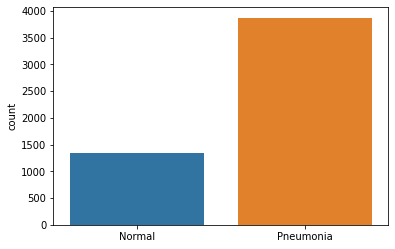

In [14]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Normal")
    else:
        l.append("Pneumonia")

# min([], default="EMPTY")
sns.countplot(l)

In [15]:
X_train = []
y_train = []

X_val = []
y_val = []

X_test = []
y_test = []

for feature, label in train:
    X_train.append(feature)
    y_train.append(label)

for feature, label in test:
    X_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    X_val.append(feature)
    y_val.append(label)

In [16]:
X_train = np.array(X_train) / 255
X_val = np.array(X_val) / 255
X_test = np.array(X_test) / 255 # normalizacion

In [18]:
# X_train[1].shape

(32, 32)

In [21]:
X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE,1)
Y_train = np.array(y_train)

X_val = X_val.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
Y_val = np.array(y_val)

X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE,1)
Y_test = np.array(y_test)

In [22]:
print(X_train.shape)

(5216, 32, 32, 1)


### Hyperparameters

In [14]:
# generic config
num_classes = 2
input_shape = (32, 32, 1)
image_size = 32  

batch_size = 16     # original 128
num_epochs = 100

In [30]:
#config ViT *** reed teori
num_heads = 2
patch_size = 4  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2                                                               
projection_dim = 128
transformer_units = [ projection_dim, projection_dim,]  # Size of the transformer layers
transformer_layers = 2

In [31]:
# **********************************************************************************************************************************
mlp_head_units = [projection_dim * 4, projection_dim * 2]  # Size of the dense layers of the final classifier <--------dude
# **********************************************************************************************************************************

In [32]:
# opp
learning_rate = 0.001
weight_decay = 0.0001

### Data agumentation

In [17]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Rescaling(scale=1./255),
        layers.experimental.preprocessing.RandomCrop(image_size, image_size),
        layers.experimental.preprocessing.RandomFlip("horizontal")
    ],
    name="data_augmentation"
)

### Implement multilayer perceptron (MLP)

In [18]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)           # gelu <----- why?
        x = layers.Dropout(dropout_rate)(x)
    return x

### Implement patch creation as a layer

In [19]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

### test segmentation patches (check)

In [20]:
image = X_train[np.random.choice(range(X_train.shape[0]))]

NameError: ignored

In [ ]:
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

In [ ]:
resized_image.shape

In [ ]:
patches = Patches(patch_size)(resized_image)

In [ ]:
patches.shape

In [ ]:
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

### Implement the patch encoding layer


The `PatchEncoder` layer will linearly transform a patch by projecting it into a
vector of size `projection_dim`. In addition, it adds a learnable position
embedding to the projected vector.

In [60]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

## Build the ViT model

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [16]:

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [13]:
create_vit_classifier().count_params()/1e6

NameError: ignored

## Compile, train, and evaluate the mode

In [8]:

def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=X_train,
        y=Y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(X_test, X_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


In [15]:
vit_classifier = create_vit_classifier()

NameError: ignored

In [68]:
history = run_experiment(vit_classifier)

Epoch 1/100
203/294 [===================>..........] - ETA: 2s - loss: 1.2985 - accuracy: 0.6118 - top-5-accuracy: 1.0000

KeyboardInterrupt: ignored